# Hotel Consumptions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR

In [2]:
# Load hotel consumptions csv
hotel_consumptions = pd.read_csv('hotel_consumptions.csv')

In [3]:
# Verify if there are 0 or NaN relevant values
(hotel_consumptions == 0).astype(int).sum(axis=0)

windSpeed       60
Temperature      0
OcupPaxs       192
Timestamp        0
CTotal           3
dtype: int64

As the data was loaded the first time, we can see that the "OcupPaxs" column has NaN values, so replacing the NaN values for 0 and converting also those values to integers is the first step.

In [4]:
# Fill all the NaN values with 0
hotel_consumptions = hotel_consumptions.fillna(0)

In [5]:
# Convert OcupPaxs values to int
hotel_consumptions['OcupPaxs'] = hotel_consumptions['OcupPaxs'].astype(int)

In [6]:
# Delete OcupPaxs with value of 0
hotel_consumptions = hotel_consumptions[hotel_consumptions.OcupPaxs != 0]

In [7]:
# Delete CTotal with value of 0
hotel_consumptions = hotel_consumptions[hotel_consumptions.CTotal != 0]

In [8]:
hotel_consumptions.head()

,windSpeed,Temperature,OcupPaxs,Timestamp,CTotal
0,11,13,363,1/1/2017 0:00,61.892143
1,11,13,363,1/1/2017 0:15,63.693636
2,11,13,363,1/1/2017 0:30,63.354167
3,11,13,363,1/1/2017 0:45,66.613846
4,11,13,363,1/1/2017 1:00,70.403636


Just for better reading and identification the columns "windSpeed", "OcupPaxs" and "CTotal" were renamed to "Wind Speed", "Guests" and "Total Consumption".

In [9]:
# Rename columns
hotel_consumptions = hotel_consumptions.rename(
    mapper={'windSpeed': 'Wind Speed', 'OcupPaxs': 'Guests', 'CTotal': 'Total Consumption'},
    axis='columns')

Two new columns were created to store the week day and the season based on the Timestamp column.

In [10]:
# Create a new column for week days
hotel_consumptions['Week Day'] = pd.to_datetime(hotel_consumptions['Timestamp'])
hotel_consumptions['Week Day'] = hotel_consumptions['Week Day'].dt.day_name()

In [11]:
# Returns season from month number
def getSeason(month):
    if 1 <= month <= 2:
        return 'Winter'
    elif 3 <= month <= 5:
        return 'Sprint'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    elif month == 12:
        return 'Winter'

In [12]:
# Add a new seasons column
hotel_consumptions['Season'] = pd.to_datetime(hotel_consumptions['Timestamp'])
hotel_consumptions['Season'] = hotel_consumptions['Season'].dt.month
hotel_consumptions['Season'] = hotel_consumptions['Season'].apply(getSeason)

In order to store "Timestamp" related columns a reindex was needed to have the "Week Day" and "Season" columns after the "Timestamp" one.

In [13]:
# Reindex columns
hotel_consumptions = hotel_consumptions.reindex(
    columns=['Wind Speed', 'Temperature', 'Guests', 'Timestamp', 'Week Day', 'Season', 'Total Consumption'])

In [14]:
hotel_consumptions.head()

,Wind Speed,Temperature,Guests,Timestamp,Week Day,Season,Total Consumption
0,11,13,363,1/1/2017 0:00,Sunday,Winter,61.892143
1,11,13,363,1/1/2017 0:15,Sunday,Winter,63.693636
2,11,13,363,1/1/2017 0:30,Sunday,Winter,63.354167
3,11,13,363,1/1/2017 0:45,Sunday,Winter,66.613846
4,11,13,363,1/1/2017 1:00,Sunday,Winter,70.403636


After these simple operations, a simple data study can be done to get for example:

**Season with more guests**

In [15]:
hotel_consumptions[["Season", "Guests"]].groupby(by="Season").sum()

,Guests
Season,
Autumn,2565178
Sprint,2605704
Summer,3875515
Winter,930214


**Week days with more energy consumption**

In [16]:
hotel_consumptions[["Week Day", "Total Consumption"]].groupby(by="Week Day").mean()

,Total Consumption
Week Day,
Friday,122.221481
Monday,121.507827
Saturday,119.444046
Sunday,119.316728
Thursday,119.850290
Tuesday,119.566387
Wednesday,117.398322


**Plot comparing the temperature and the number of guests**

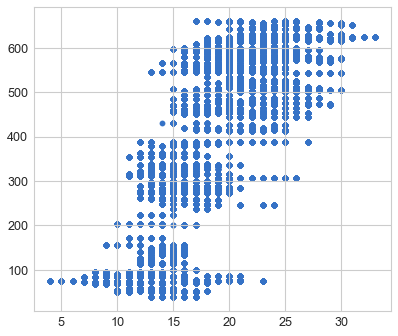

In [17]:
jtplot.style()

x = hotel_consumptions['Temperature'].tolist()
y = hotel_consumptions['Guests'].tolist()

plt.scatter(x, y)
plt.show()

One of the requirements to train a model, is that every value should be float convertible, this means that new columns based on the "Timestamp" one should be created and the "Season" and "Week Day" ones should be changed. 

In [ ]:
# Change Season column to store the month
hotel_consumptions['Season'] = pd.to_datetime(hotel_consumptions['Timestamp'])
hotel_consumptions['Season'] = hotel_consumptions['Season'].dt.month

In [ ]:
# Rename Season column to Month
hotel_consumptions = hotel_consumptions.rename(
    mapper={'Season': 'Month'},
    axis='columns')

In [ ]:
# Change the Week Day column, to store the week day number instead of the week day name
# Monday=0, Tuesday=1, Wednesday=2, Thursday=3, Friday=4, Saturday=5, Sunday=6
hotel_consumptions['Week Day'] = pd.to_datetime(hotel_consumptions['Timestamp'])
hotel_consumptions['Week Day'] = hotel_consumptions['Week Day'].dt.dayofweek

In [ ]:
# Add a new day column 
hotel_consumptions['Day'] = pd.to_datetime(hotel_consumptions['Timestamp'])
hotel_consumptions['Day'] = hotel_consumptions['Day'].dt.day

In [ ]:
# Add new year column
hotel_consumptions['Year'] = pd.to_datetime(hotel_consumptions['Timestamp'])
hotel_consumptions['Year'] = hotel_consumptions['Year'].dt.year

In [ ]:
# Reindex columns
hotel_consumptions = hotel_consumptions.reindex(
    columns=['Wind Speed', 'Temperature', 'Guests', 'Timestamp', 'Week Day', 'Day', 'Month', 'Year', 'Total Consumption'])

In [ ]:
hotel_consumptions = hotel_consumptions.drop(columns=['Timestamp'])

In [ ]:
hotel_consumptions.head()

### Prediction using Decision Tree Regression

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression.  
The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [ ]:
hotel_consumptions.describe()

In [ ]:
X, y = hotel_consumptions.loc[:,:'Year'].values, hotel_consumptions['Total Consumption'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False, train_size=.7)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor().fit(X_train, y_train)
score = dt.score(X_test, y_test)
score

In [ ]:
y_pred = dt.predict(X_test)

In [ ]:
predictionsDTR = pd.DataFrame({'Actual Consumption':y_test, 'Predicted Consumption':y_pred}) 
predictionsDTR

### Prediction using Linear Regression

Linear regression method fits a linear model with coefficients w = (w1,w2,...,wp) to minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

In [ ]:
X, y = hotel_consumptions.loc[:,:'Year'].values, hotel_consumptions['Total Consumption'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False, train_size=.7)

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
score = lr.score(X_test, y_test)
score

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
predictionsLR = pd.DataFrame({'Actual Consumption':y_test, 'Predicted Consumption':y_pred}) 
predictionsLR

In order to avoid **overfitting**, grid cross validation can be used.

In [ ]:
# list_of_params = [.001, 0.01, 0.1, 1, 10, 100]
# param_grid = {
#        'C': list_of_params, 
#        'gamma': list_of_params
#    } 

# scores = GridSearchCV(estimator=SVR(), 
#                      param_grid=param_grid, 
#                      cv=5, 
#                      return_train_score=True).fit(x_train, y_train)

# print(f'best score: { scores.best_score_}\n best params: {scores.best_params_}\n score over test: {scores.score(x_test, y_test)}\n\n Best estimator: {scores.best_estimator_}')

### Prediction using linear SVM

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

In [ ]:
X, y = hotel_consumptions.loc[:,:'Year'].values, hotel_consumptions['Total Consumption'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False, train_size=.7)

In [ ]:
from sklearn.svm import LinearSVR

svm = LinearSVR(C=100,
                max_iter=1000000,
                random_state=1).fit(X_train, y_train)

score = svm.score(X_test, y_test)
score        

In [ ]:
y_pred = svm.predict(X_test)

In [ ]:
predictionsSVM = pd.DataFrame({'Actual Consumption':y_test, 'Predicted Consumption':y_pred}) 
predictionsSVM